### HPC Project

General Remarks: This project consists of two stages. The deadline for the first stage is Friday 8th March. The deadline for the second stage is Friday 29 March. There will be no extension apart from approved extenuating circumstances. Each part of the project counts as 30% of the total module mark. The module can only be passed if at least 50% of the possible project marks have been achieved.

### Stage 1

We are considering the poisson equation 
$$-\nabla \cdot \left(\sigma(x, y)\nabla\right)u(x, y) = f(x, y)$$ 
for $(x, y)\in [0, 1]\times [0, 1]$ with boundary conditions $u(x, y) = 0$. 

The goal of Stage 1 is to gain experience with iterative solvers. The broad strategy is as follows:

        1. Implement a finite difference discretisation of the above equation in OpenCL
        2. Demonstrate that your implementation works by comparing with FEniCS.
        3. Test the performance of iterative solvers as you refine the discretisation.
        
For the first point you will use a standard centered finite difference scheme. Let $u_{i, j} := u(x_i, y_j)$ be the solution on given grid point. We can approximate the application of the left-hand side operator $\nabla \cdot \left(\sigma(x, y)\nabla\right)$ through
$$
\nabla \cdot \left(\sigma(x, y)\nabla\right)u \approx \frac{\left(\sigma_{i+1/2, j}\frac{\left(u_{i+1,j} - u_{i,j}\right)}{h}\right) - \left(\sigma_{i-1/2, j}\frac{\left(u_{i,j} - u_{i-1,j}\right)}{h}\right)}{h} + \frac{\left(\sigma_{i, j+1/2}\frac{\left(u_{i,j+1} - u_{i,j}\right)}{h}\right) - \left(\sigma_{i, j-1/2}\frac{\left(u_{i,j} - u_{i,j-1}\right)}{h}\right)}{h}
$$
(be careful with the additional $-$ sign in the PDE).

Here, we approximate $\sigma_{i+1/2,j}\approx \frac{1}{2}\left(\sigma_{i+1,j} + \sigma_{i, j}\right)$ and $\sigma_{i,j+1/2}\approx \frac{1}{2}\left(\sigma_{i,j+1} + \sigma_{i, j}\right)$ and similarly with the other values of $\sigma$.

You should implement this iterative scheme in a matrix free way, meaning that your OpenCL implementation should involve a function that takes your vector of $u$ values and returns the discrete application of the above operator onto this vector of values. Turn this function into a linear operator class using the LinearOperator object from scipy. This allows you to apply the various iterative solvers from scipy.

To validate your implementation you should compare your own solution for a given set of right-hand side data with a FEniCS implementation of this problem. Validation is important and it is good practice in Scientific Computing to always validate model problems against existing codes.

Once you know that your implementation works experiment with different iterative solvers. In particular try gmres and bicgstab. You can use the Scipy implementations. Demonstrate the convergence by plotting the residual against the iteration count (using a log10 scale on the y axis (see semilogy plots in Matplotlib). How does the convergence change if you increase the number of discretisation points in each space dimension? Try to experimentally obtain a relationship between number of discretization points and the rate of convergence.

To make matters interesting, for your convergence plots consider a random distribution for $\sigma$, that is use $\sigma(x, y) = e^{-S(x, y)}$, where $S(x, y)$ is field of normally distributed random numbers. Your right-hand side does not matter much for convergence plots and you can use for example the function $f(x) = 1$ here.



In [1]:
# !conda install -c conda-forge --yes --verbose pyopencl pocl

### Stage 2

For Stage 2 we now consider the parabolic equation 
$$
u_t = \nabla \cdot \left(\sigma(x, y)\nabla\right)u
$$ 

with the same space domain as in Stage 1 and time $t$ starting at $0$. Initial conditions are given as $u(x, y, 0) = g(x, y)$ at time $t=0$ and $u(x, y, t) = 0$ on the boundary for all $t\geq 0$. For stage 2 you are asked to develop an OpenCL implementation of this parabolic PDE. For the time discretisation you can use a simple forward difference scheme given as 
$$
u_t(x, y)\approx \frac{u(x, y, t+\Delta t) - u(x, y, t)}{\Delta t}.
$$

Demonstrate the time-domain solver for some interesting choices of initial conditions and a given random field for $\sigma$ as in Stage 1. This is a realistic simulation of a time-dependent diffusion process in two dimensions. a good initial condition is to put some weight into the middle of the domain and observe how it slowly diffuses in time.

For Stage 2 performance is relevant. Your solution **must** contain a directly runnable command that measures the time of performing 10 forward time steps and returns the results in seconds. For this write a Python function that takes the current iterate and performs one forward time step with your OpenCL implementation. The function should then be called 10 times in your performance measurements. I need to be able to directly run your benchmarking code.

**Submission**

For each Stage your submission must consist of two parts, a Jupyter Notebook that demonstrates all the codes and a pdf document that explains the implementation, demonstrates experiments, gives performance results, etc. For each Stage your pdf document must be no more than 5 pages in length. The pdf for Stage 2 can be a continuation of the Stage 1 document. You need not repeat the introduction to your code. 

The Jupyter notebook for each Stage must be executable by pressing "Restart and Run All" from a fresh Notebook. Syntax errors, missing variables or other things that make the Notebook not execute are automatically marked with 0 marks for the code. 

The codes will be tested in a Python 3.6 environment. Each Notebook should run in a reasonably short amount of time (around 2 minutes max). If it runs too long I will interrupt it and not mark it. Hence, not every configuration from your report needs to be in the demonstration code. But it should demonstrate all experiments that you perform, e.g. when running convergence tests only a smaller faster running configuration needs to be in the Jupyter notebook while your report also shows larger sizes.

**You have almost three weeks for Stage 1 and another 2 weeks for Stage 2. Use the time and do not start too late!!**

**Marking:** For Stage 1 marks will be as follows: Quality of the report: 50%, Code quality: 50%. For Stage 2 it will be: Report: 40%, Code quality: 50%, Performance: 10%.

In [2]:
# import all necessary packages
import pyopencl as cl
import numpy as np
import scipy.sparse.linalg as lin
import matplotlib.pyplot as plt
from numpy.random import normal
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from timeit import timeit
KERNEL = """
#pragma OPENCL EXTENSION cl_khr_fp64 : enable
#define index(i, j)  (((i) * size) + (j))

__kernel void calc(__global const double *current, 
                   __global const double *s, 
                   __global double *next,
                   const int size,
                   const double ratio) {
    int i = get_global_id(0), j = get_global_id(1);
    if (i == 0 || i + 1 == size ||
        j == 0 || j + 1 == size) {
        next[index(i, j)] = current[index(i, j)];
        return;
    }
    
    double sij  = s[index(i, j)];
    double sip1 = (s[index(i + 1, j)]+sij) / 2,
           sim1 = (s[index(i - 1, j)]+sij) / 2,
           sjp1 = (s[index(i, j + 1)]+sij) / 2,
           sjm1 = (s[index(i, j - 1)]+sij) / 2;
    double uij  = current[index(i, j)],
           uip1 = current[index(i + 1, j)],
           uim1 = current[index(i - 1, j)],
           ujp1 = current[index(i, j + 1)],
           ujm1 = current[index(i, j - 1)];
    next[index(i, j)] = current[index(i, j)] + 
        ratio * (sip1 * (uip1 - uij) +
                 sim1 * (uim1 - uij) +
                 sjp1 * (ujp1 - uij) +
                 sjm1 * (ujm1 - uij));
}
"""


class Work:
    def __init__(self):
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.flags = cl.mem_flags

    def compile(self, kernel):
        self.prog = cl.Program(self.ctx, kernel).build()
        return self.prog

    def outbuffer(self, shape, dtype):
        u = np.zeros(shape=shape, dtype=dtype)
        buffer = cl.Buffer(self.ctx, self.flags.READ_WRITE |
                           self.flags.ALLOC_HOST_PTR, u.nbytes)
        return ("buffer", shape, dtype, buffer)

    def inarray(self, nparray):
        buffer = cl.Buffer(self.ctx, self.flags.READ_WRITE |
                           self.flags.COPY_HOST_PTR, hostbuf=nparray)
        return ("buffer", nparray.shape, nparray.dtype, buffer)

    def readbuffer(self, bufferspec):
        _, shape, dtype, buffer = bufferspec
        empty = np.empty(shape, dtype)
        cl.enqueue_copy(self.queue, empty, buffer)
        return empty

    def readsized(self, bufferspec):
        _, shape, dtype, buffer = bufferspec
        empty = np.empty(shape, dtype)
        cl.enqueue_copy(self.queue, empty, buffer)
        return empty

    def run(self, name, g, l, *args):
        realargs = []
        for arg in args:
            if type(arg) == tuple and arg[0] == "buffer":
                realargs.append(arg[3])
            else:
                realargs.append(arg)
        return self.prog.__getattr__(name)(self.queue, g, l, *realargs)


class Stage2:
    def __init__(self, size, dt = None):
        self.size = size
        self.work = work = Work()
        self.sigma = self.sigma_function()
        self.gauss = self.gauss_function()
        h = 1 / self.size
        dt = dt or 1e-6
        self.ratio = np.float64(dt / (h * h))
        work.compile(KERNEL)

    def linspace(self):
        return np.linspace(0, 1, self.size, endpoint=False, dtype='float64')

    def linspace2(self):
        return np.meshgrid(self.linspace(), self.linspace())

# set sigma
    def sigma_function(self):
        exps = -normal(0, 0.02, self.size * self.size)
        return np.array(np.exp(exps))

# set g(x,y)
    def gauss_function(self):
        x, y = self.linspace2()
        matrix = multivariate_normal.pdf(np.dstack([x.flat, y.flat]),
                                         mean=np.array([0.5, 0.5]),
                                         cov=np.array([0.01, 0.01]))
        ret = np.zeros_like(matrix)
        for i in range(1, self.size - 1):
            for j in range(1, self.size - 1):
                ret[i * self.size + j] = matrix[i * self.size + j]
        return ret

    def operator(self, u):
        buf = self.work.outbuffer((self.size * self.size, ), 'float64')
        self.work.run('calc', (self.size, self.size), (1, 1),
                      self.work.inarray(u),
                      self.work.inarray(self.sigma),
                      buf,
                      np.int32(self.size),
                      self.ratio)
        return self.work.readbuffer(buf)

# solving equation step by step and use for showing condition on assumed step
    def solve_step(self, nstep):
        operator = lin.LinearOperator((self.size * self.size, self.size * self.size),
                                      self.operator)
        acc = self.gauss
        for i in range(0, nstep):
            acc = operator(acc)
        self.solution1= acc
        return acc
     
    def solve(self, nstep = 10):
        operator = lin.LinearOperator((self.size * self.size, self.size * self.size),
                                      self.operator)
        acc = self.gauss
        for i in range(0, nstep):
            acc = operator(acc)
        self.solution = acc
        return acc

    def plot(self):
        x, y = self.linspace2()
        z = self.solution1.reshape(self.size, self.size)
        a3d = Axes3D(plt.figure())
        a3d.plot_surface(x, y, z, rstride=1, cstride=1, cmap='rainbow')
        plt.show()
        
def timing():
    global time_obj
    time_obj = Stage2(100, 10)
#     time_obj = Stage2(size, step)
    print(timeit("time_obj.solve()", setup="from __main__ import time_obj", number=100))

    
s = Stage2(100, 1e-4)
# it = s.step_solve()
print("Begin-first trial")

Begin-first trial


Initial condition

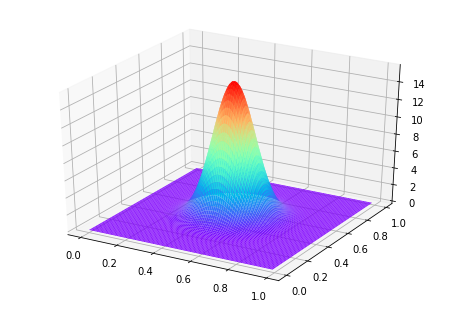

In [3]:
s.solve_step(1)
s.plot()

The iteration 1

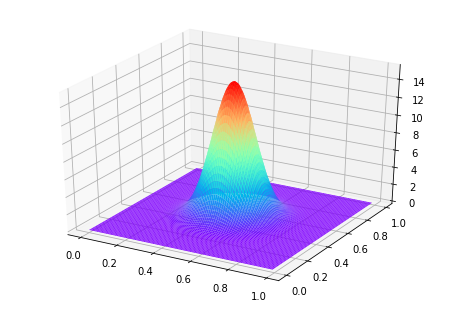

In [4]:
s.solve_step(2)
s.plot()

The iteration 2

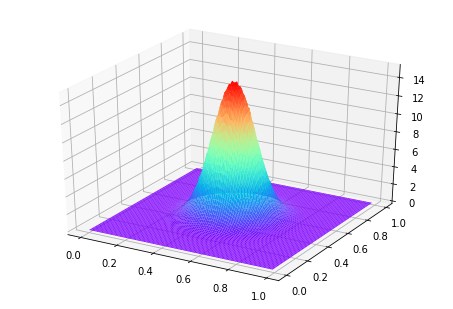

In [5]:
s.solve_step(3)
s.plot()

The iteration 3

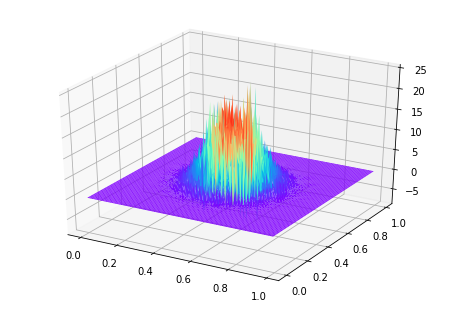

In [6]:
s.solve_step(5)
s.plot()

In [7]:
s = Stage2(100, 1e-5)
# it = s.step_solve()
print("Begin-second trial")

Begin-second trial


Initial condition

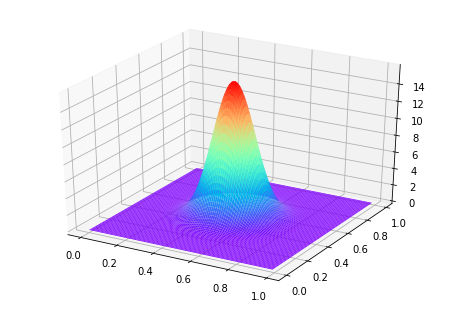

In [8]:
s.solve_step(1)
s.plot()

The iteration 2

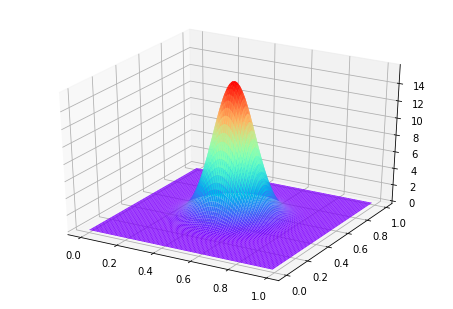

In [9]:
s.solve_step(3)
s.plot()

The iteration 10

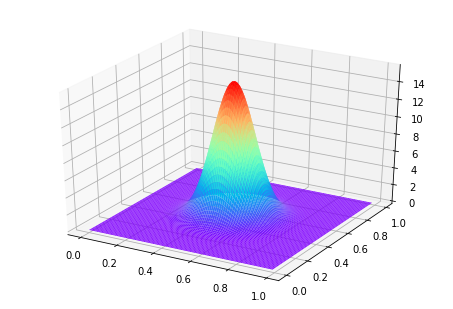

In [10]:
s.solve_step(11)
s.plot()

The iteration 100

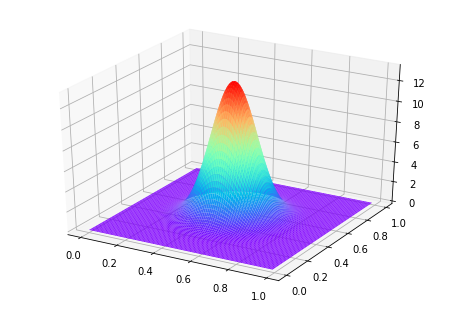

In [11]:
s.solve_step(101)
s.plot()

The iteration 1000

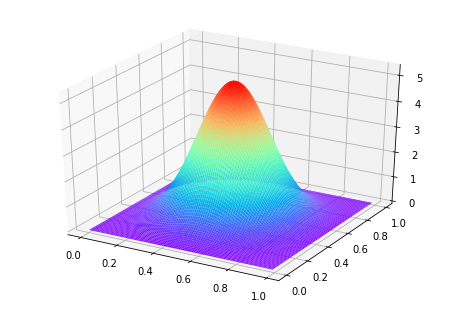

In [12]:
s.solve_step(1001)
s.plot()

In [13]:
s = Stage2(50, 1e-4)
# it = s.step_solve()
print("Begin-third trial")

Begin-third trial


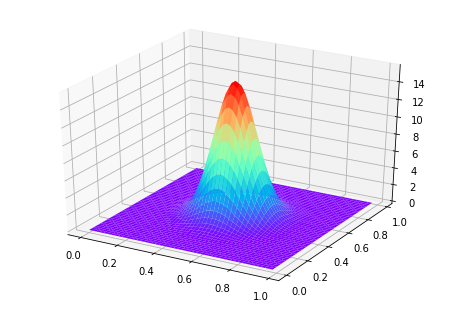

In [14]:
s.solve_step(1)
s.plot()

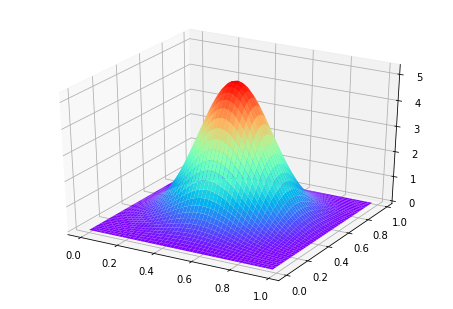

In [15]:
s.solve_step(101)
s.plot()

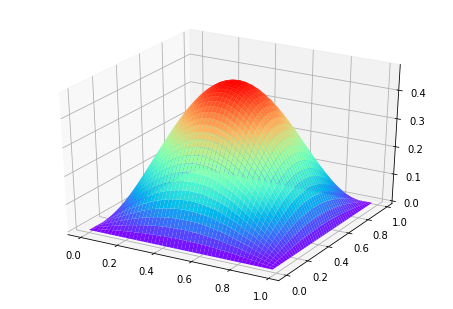

In [16]:
s.solve_step(1001)
s.plot()

The time cost when size = 100 and steps = 10

In [19]:
s = Stage2(100)
s.solve()
timing()

1.6452052999993612
